# Extended Permutation Testing & Visualization  
## Estrus-Linked Locomotor Plateau Structure  
### Morph2REP (Study 1001, v2025v3.3)

This notebook extends the primary plateau detection analysis
with additional permutation testing and visualization.

Rather than focusing only on detection,
this notebook emphasizes:

- Per-cage structure
- Per-replicate structure
- Variability across cages
- Graphical comparison of observed vs null distributions

The goal is to evaluate how consistently estrus-like
locomotor plateaus emerge across spatial scales.


## Scientific Focus

Estrus is hypothesized to produce a prolonged dark-phase
plateau of near-peak locomotor activity.

This notebook asks:

1. Is plateau structure detectable within individual cages?
2. Does structure persist at the replicate (population) level?
3. How variable is detection strength across cages?
4. Are observed high-plateau days stronger than expected by chance?

We address these questions using permutation testing
combined with detailed visual diagnostics.


## 1. Data Preparation

- Load 60-second locomotion
- Define dark phase
- Compute per-animal daily plateau duration
- Aggregate to cage and replicate levels


## 2. Per-Cage Plateau Structure & Permutation Testing

This section evaluates estrus-like plateau structure
within each cage using both visualization and
permutation-based inference.

---

### Step 1: Visualize Per-Cage Plateau Structure

For each cage:

- Compute mean plateau duration per day (across animals)
- Rank days in descending order
- Identify top-k candidate estrus-like days

Visual diagnostics include:

- Line or bar plots of daily mean plateau duration
- Highlighting of top-k days
- Animal × day heatmaps to assess within-cage consistency

Purpose:
Determine whether a visually distinct high-plateau day
(or set of days) exists before statistical testing.

---

### Step 2: Per-Cage Permutation Test

Test statistic:

T_obs = mean(top-k days) − mean(rest days)

Permutation procedure:

1. Shuffle day labels within each animal
   (preserves animal-level variance and structure)

2. Recompute:
   - Daily cage mean plateau duration
   - Day ranking
   - T_perm

3. Repeat N times (e.g., 10,000) to build null distribution

---

### Empirical p-value

p = proportion of permutations where T_perm ≥ T_obs

Small p-value:
→ Evidence of structured estrus-like plateau within cage

Large p-value:
→ Plateau strength not distinguishable from random variation

---

### Output per Cage

- Observed T_obs
- Empirical p-value
- Top-ranked day
- Null distribution visualization



In [1]:
import duckdb
import pandas as pd
import numpy as np

# ============================================================
# CONFIG (yours)
# ============================================================
S3_BASE = "s3://jax-envision-public-data/study_1001/2025v3.3/tabular"

VEHICLE_CAGES = {
    "Rep1": {
        "cages": [4918, 4922, 4923],
        "start": "2025-01-10 06:00:00",
        "end":   "2025-01-22 06:00:00",
    },
    "Rep2": {
        "cages": [4928, 4929, 4934],
        "start": "2025-01-25 06:00:00",
        "end":   "2025-02-04 06:00:00",
    },
}

# Dark phase minutes relative to 6AM lights-on baseline:
# 6PM–6AM => minutes 720..1439
DARK_START = 720
DARK_END   = 1440

PLATEAU_Q = 85
RNG_SEED = 0
N_PERM = 10000

ACTIVITY_CACHE = {}

# ============================================================
# LOAD DATA (your function; unchanged)
# ============================================================
def load_activity(cage_id, start, end):
    key = (cage_id, start, end)
    if key in ACTIVITY_CACHE:
        return ACTIVITY_CACHE[key]

    conn = duckdb.connect()
    conn.execute("INSTALL httpfs; LOAD httpfs;")
    conn.execute("SET s3_region='us-east-1';")

    query = f"""
    SELECT
        time,
        animal_id,
        value
    FROM read_parquet(
        '{S3_BASE}/cage_id={cage_id}/date=*/animal_activity_db.parquet'
    )
    WHERE
        name = 'animal_bouts.locomotion'
        AND resolution = 60
        AND time BETWEEN TIMESTAMP '{start}' AND TIMESTAMP '{end}'
    ORDER BY time
    """

    df = conn.execute(query).fetchdf()
    conn.close()

    df["time"] = pd.to_datetime(df["time"])
    ACTIVITY_CACHE[key] = df
    return df

# ============================================================
# PLATEAU DAILY (per cage)
# Robust threshold per animal:
#   1) build minute-of-day series (0..1439) across whole window
#   2) take MEDIAN per minute-of-day
#   3) threshold = qth percentile of that median profile DURING DARK
# Plateau duration per day = #dark minutes with value >= threshold
# ============================================================
def plateau_daily_per_cage(
    cage_id: int,
    start: str,
    end: str,
    q: float = PLATEAU_Q,
) -> pd.DataFrame:
    df = load_activity(cage_id, start, end).copy()
    if df.empty:
        return pd.DataFrame(columns=["cage_id","animal_id","day","plateau_duration_min","threshold","n_dark_minutes"])

    start_ts = pd.to_datetime(start)

    # minute-of-study (integer minutes since start)
    df["minute_since_start"] = ((df["time"] - start_ts).dt.total_seconds() // 60).astype(int)
    df["day"] = (df["minute_since_start"] // 1440).astype(int) + 1  # 1-indexed days
    df["minute_in_day"] = (df["minute_since_start"] % 1440).astype(int)

    # Keep only dark phase minutes for plateau duration counting
    is_dark = (df["minute_in_day"] >= DARK_START) & (df["minute_in_day"] < DARK_END)
    df_dark = df.loc[is_dark, ["animal_id","day","minute_in_day","value"]].copy()

    # Robust per-animal threshold from MEDIAN minute-of-day profile (dark only)
    # median_profile: (animal_id, minute_in_day) -> median(value)
    median_profile = (
        df_dark
        .groupby(["animal_id","minute_in_day"], as_index=False)["value"]
        .median()
        .rename(columns={"value":"median_value"})
    )

    # threshold per animal: qth percentile of median_value across dark minutes
    thr = (
        median_profile
        .groupby("animal_id")["median_value"]
        .apply(lambda s: float(np.nanpercentile(s.to_numpy(), q)))
        .reset_index()
        .rename(columns={"median_value":"threshold"})
    )

    df_dark = df_dark.merge(thr, on="animal_id", how="left")
    df_dark["is_plateau"] = (df_dark["value"] >= df_dark["threshold"]).astype(int)

    # plateau duration per animal per day = number of dark minutes above threshold
    daily = (
        df_dark
        .groupby(["animal_id","day"], as_index=False)
        .agg(
            plateau_duration_min=("is_plateau","sum"),
            n_dark_minutes=("is_plateau","size"),
        )
        .merge(thr, on="animal_id", how="left")
    )
    daily.insert(0, "cage_id", cage_id)
    return daily

def rank_days_within_cage(df_daily: pd.DataFrame) -> pd.DataFrame:
    """
    Returns: one row per day with mean/median across animals + rank (1 = highest mean).
    """
    if df_daily.empty:
        return pd.DataFrame(columns=["cage_id","day","mean_plateau","median_plateau","sd_plateau","n_animals","rank_mean_desc"])

    day_stats = (
        df_daily
        .groupby(["cage_id","day"], as_index=False)["plateau_duration_min"]
        .agg(
            mean_plateau="mean",
            median_plateau="median",
            sd_plateau="std",
            n_animals="count",
        )
        .sort_values(["cage_id","mean_plateau"], ascending=[True, False])
    )
    day_stats["rank_mean_desc"] = day_stats.groupby("cage_id")["mean_plateau"].rank(ascending=False, method="min").astype(int)
    return day_stats.sort_values(["cage_id","rank_mean_desc","day"]).reset_index(drop=True)

# ============================================================
# PERMUTATION TEST (per cage; same null you used)
# ============================================================
def _day_means(df_daily: pd.DataFrame) -> pd.Series:
    return df_daily.groupby("day")["plateau_duration_min"].mean().sort_index()

def _stat_max_mean_day(day_means: pd.Series) -> float:
    return float(day_means.max())

def _stat_topk_minus_rest(day_means: pd.Series, k: int) -> float:
    vals = day_means.to_numpy()
    if len(vals) <= k:
        return float("nan")
    s = np.sort(vals)
    topk = s[-k:]
    rest = s[:-k]
    return float(topk.mean() - rest.mean())

def permutation_test_per_cage(
    df_daily: pd.DataFrame,
    stat: str = "topk_minus_rest",
    k: int = 3,
    n_perm: int = N_PERM,
    seed: int = RNG_SEED,
) -> dict:
    """
    Null: within each animal, plateau values are not tied to specific days.
    Permute: shuffle day labels within each animal.
    One-sided p-value (large statistic = more structured / estrus-like).
    """
    if df_daily.empty:
        return {"T_obs": np.nan, "p_value": np.nan, "T_perm": np.array([]), "day_means_obs": pd.Series(dtype=float)}

    rng = np.random.default_rng(seed)
    grouped = list(df_daily.groupby("animal_id", sort=False))

    dm_obs = _day_means(df_daily)
    if stat == "max_mean_day":
        T_obs = _stat_max_mean_day(dm_obs)
    elif stat == "topk_minus_rest":
        T_obs = _stat_topk_minus_rest(dm_obs, k=k)
    else:
        raise ValueError("stat must be 'max_mean_day' or 'topk_minus_rest'")

    T_perm = np.empty(n_perm, dtype=float)
    for i in range(n_perm):
        parts = []
        for _, g in grouped:
            g2 = g.copy()
            g2["day"] = rng.permutation(g2["day"].to_numpy())
            parts.append(g2)
        perm_df = pd.concat(parts, ignore_index=True)

        dm = _day_means(perm_df)
        if stat == "max_mean_day":
            T_perm[i] = _stat_max_mean_day(dm)
        else:
            T_perm[i] = _stat_topk_minus_rest(dm, k=k)

    p_value = (np.sum(T_perm >= T_obs) + 1) / (n_perm + 1)

    return {
        "T_obs": float(T_obs),
        "p_value": float(p_value),
        "T_perm": T_perm,
        "day_means_obs": dm_obs,
    }

# ============================================================
# RUN ALL VEHICLE CAGES, PER CAGE:
#   - compute daily plateau
#   - rank days
#   - run permutation test per cage
# ============================================================
def run_vehicle_per_cage(
    cfg: dict,
    q: float = PLATEAU_Q,
    stat: str = "topk_minus_rest",
    k: int = 3,
    n_perm: int = N_PERM,
    seed: int = RNG_SEED,
):
    all_daily = []
    all_ranks = []
    test_rows = []

    for cage_id in cfg["cages"]:
        daily = plateau_daily_per_cage(cage_id, cfg["start"], cfg["end"], q=q)
        all_daily.append(daily)

        ranks = rank_days_within_cage(daily)
        all_ranks.append(ranks)

        res = permutation_test_per_cage(daily, stat=stat, k=k, n_perm=n_perm, seed=seed)
        test_rows.append({
            "cage_id": cage_id,
            "stat": stat,
            "k": (k if stat == "topk_minus_rest" else np.nan),
            "T_obs": res["T_obs"],
            "p_value": res["p_value"],
            "top_day_by_mean": (int(res["day_means_obs"].idxmax()) if len(res["day_means_obs"]) else np.nan),
            "max_day_mean": (float(res["day_means_obs"].max()) if len(res["day_means_obs"]) else np.nan),
        })

    df_daily_all = pd.concat(all_daily, ignore_index=True) if len(all_daily) else pd.DataFrame()
    df_ranks_all = pd.concat(all_ranks, ignore_index=True) if len(all_ranks) else pd.DataFrame()
    df_tests = pd.DataFrame(test_rows).sort_values("cage_id").reset_index(drop=True)

    return df_daily_all, df_ranks_all, df_tests

# ----------------------------
# EXECUTE: Rep1 + Rep2
# ----------------------------
rep1_daily_all, rep1_ranks, rep1_tests = run_vehicle_per_cage(
    VEHICLE_CAGES["Rep1"], q=PLATEAU_Q, stat="topk_minus_rest", k=3, n_perm=N_PERM, seed=RNG_SEED
)

rep2_daily_all, rep2_ranks, rep2_tests = run_vehicle_per_cage(
    VEHICLE_CAGES["Rep2"], q=PLATEAU_Q, stat="topk_minus_rest", k=3, n_perm=N_PERM, seed=RNG_SEED
)

print("\n=== Rep1: per-cage permutation tests ===")
print(rep1_tests)

print("\n=== Rep1: per-cage day rankings (top 10 rows) ===")
print(rep1_ranks.sort_values(["cage_id","rank_mean_desc","day"]).head(10))

print("\n=== Rep2: per-cage permutation tests ===")
print(rep2_tests)

print("\n=== Rep2: per-cage day rankings (top 10 rows) ===")
print(rep2_ranks.sort_values(["cage_id","rank_mean_desc","day"]).head(10))

# If you want: see full ranked days for a specific cage
# cage = 4918
# print(rep1_ranks.query("cage_id == @cage").sort_values("rank_mean_desc"))


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


=== Rep1: per-cage permutation tests ===
   cage_id             stat  k      T_obs   p_value  top_day_by_mean  \
0     4918  topk_minus_rest  3  45.407407  0.074493               12   
1     4922  topk_minus_rest  3  37.296296  0.001100               12   
2     4923  topk_minus_rest  3  60.444444  0.000600               12   

   max_day_mean  
0    238.000000  
1    213.333333  
2    236.333333  

=== Rep1: per-cage day rankings (top 10 rows) ===
   cage_id  day  mean_plateau  median_plateau  sd_plateau  n_animals  \
0     4918   12    238.000000           231.0   40.951190          3   
1     4918    3    184.666667           192.0   13.576941          3   
2     4918    7    172.666667           186.0   31.214313          3   
3     4918   10    165.333333           160.0   45.236416          3   
4     4918    2    162.000000           158.0   34.176015          3   
5     4918    9    160.000000           164.0   30.199338          3   
6     4918   11    159.333333           16

In [2]:
all_ranks = pd.concat([
    rep1_ranks.assign(replicate="Rep1"),
    rep2_ranks.assign(replicate="Rep2")
], ignore_index=True)

for (rep, cage_id), df_cage in all_ranks.groupby(["replicate","cage_id"]):
    print(f"\n========== {rep} | Cage {cage_id} ==========")
    print(
        df_cage
        .sort_values("rank_mean_desc")
        .to_string(index=False)
    )



========== Rep1 | Cage 4918 ==========
 cage_id  day  mean_plateau  median_plateau  sd_plateau  n_animals  rank_mean_desc replicate
    4918   12    238.000000           231.0   40.951190          3               1      Rep1
    4918    3    184.666667           192.0   13.576941          3               2      Rep1
    4918    7    172.666667           186.0   31.214313          3               3      Rep1
    4918   10    165.333333           160.0   45.236416          3               4      Rep1
    4918    2    162.000000           158.0   34.176015          3               5      Rep1
    4918    9    160.000000           164.0   30.199338          3               6      Rep1
    4918   11    159.333333           169.0   31.628047          3               7      Rep1
    4918    1    158.333333           161.0   37.072002          3               8      Rep1
    4918    8    155.000000           156.0    5.567764          3               9      Rep1
    4918    6    144.000000   

In [3]:
import pandas as pd
import numpy as np

# ------------------------------------------------------------
# Event timestamps you provided (naive timestamps; assumed same TZ as your data)
# ------------------------------------------------------------
EVENTS = {
    "Rep1": {
        "dose_times": [
            "2025-01-14 06:00:00",
            "2025-01-17 17:00:00",
        ],
        "cage_change_time": "2025-01-15 12:00:00",
    },
    "Rep2": {
        "dose_times": [
            "2025-01-28 17:00:00",
            "2025-01-31 06:00:00",
        ],
        "cage_change_time": "2025-01-29 12:00:00",
    },
}

# ------------------------------------------------------------
# Helpers
# ------------------------------------------------------------
def _event_day_index(event_ts: str, start_ts: str) -> int:
    """Convert an absolute event timestamp to the 1-indexed day number in the replicate window."""
    event = pd.to_datetime(event_ts)
    start = pd.to_datetime(start_ts)
    return int(np.floor((event - start).total_seconds() / (24 * 3600))) + 1

def _day_to_date(day: int, start_ts: str) -> pd.Timestamp:
    """Map 1-indexed day number -> date (at start_ts + (day-1) days)."""
    start = pd.to_datetime(start_ts)
    return start + pd.to_timedelta(day - 1, unit="D")

def pick_top_k_spaced_days(day_stats: pd.DataFrame, k: int = 3, min_gap_days: int = 3) -> pd.DataFrame:
    """
    Greedy pick: highest mean_plateau days, requiring abs(day_i - day_j) >= min_gap_days.
    Expects columns: day, mean_plateau
    """
    cand = day_stats.sort_values("mean_plateau", ascending=False).reset_index(drop=True)
    chosen = []
    for _, row in cand.iterrows():
        d = int(row["day"])
        if all(abs(d - int(c["day"])) >= min_gap_days for c in chosen):
            chosen.append(row)
        if len(chosen) >= k:
            break
    if len(chosen) == 0:
        return day_stats.iloc[0:0].copy()
    return pd.DataFrame(chosen)

def choose_estrus_days_and_flag(
    ranks_df: pd.DataFrame,
    rep_label: str,
    rep_cfg: dict,
    k: int = 3,
    min_gap_days: int = 3,
) -> pd.DataFrame:
    """
    For each cage:
      - pick top-k days by mean plateau duration, spaced by >= min_gap_days
      - flag if chosen day is on or day-after a cage change day or dose day
    Input ranks_df expected columns (from your rank_days_within_cage):
      cage_id, day, mean_plateau, median_plateau, sd_plateau, n_animals, rank_mean_desc
    """
    start_ts = rep_cfg["start"]

    # Compute event day indices in this replicate window
    dose_days = [_event_day_index(t, start_ts) for t in EVENTS[rep_label]["dose_times"]]
    cage_change_day = _event_day_index(EVENTS[rep_label]["cage_change_time"], start_ts)

    def _is_on_or_after(day: int, event_day: int) -> bool:
        return day == event_day or day == event_day + 1

    out_rows = []
    for cage_id, df_cage in ranks_df.groupby("cage_id", sort=True):
        picked = pick_top_k_spaced_days(df_cage, k=k, min_gap_days=min_gap_days).copy()
        if picked.empty:
            continue

        picked["replicate"] = rep_label
        picked["cage_id"] = cage_id

        # Add absolute date for readability
        picked["day_date"] = picked["day"].apply(lambda d: _day_to_date(int(d), start_ts))

        # Flag cage change (on or day-after)
        picked["cage_change_day_index"] = cage_change_day
        picked["is_on_or_after_cage_change"] = picked["day"].apply(lambda d: _is_on_or_after(int(d), cage_change_day))

        # Flag doses (on or day-after)
        picked["dose_day_indices"] = [dose_days] * len(picked)
        picked["is_on_or_after_any_dose"] = picked["day"].apply(
            lambda d: any(_is_on_or_after(int(d), ed) for ed in dose_days)
        )
        # Optional: which dose day triggered the flag (comma-separated)
        picked["dose_trigger_days"] = picked["day"].apply(
            lambda d: ",".join(str(ed) for ed in dose_days if _is_on_or_after(int(d), ed)) or ""
        )

        # Keep a tidy column set
        picked = picked[[
            "replicate","cage_id","day","day_date",
            "mean_plateau","median_plateau","sd_plateau","n_animals","rank_mean_desc",
            "cage_change_day_index","is_on_or_after_cage_change",
            "dose_day_indices","is_on_or_after_any_dose","dose_trigger_days"
        ]].sort_values(["cage_id","mean_plateau"], ascending=[True, False])

        out_rows.append(picked)

    return pd.concat(out_rows, ignore_index=True) if out_rows else pd.DataFrame()

# ------------------------------------------------------------
# RUN (assumes rep1_ranks and rep2_ranks already exist)
# ------------------------------------------------------------
rep1_top3_flagged = choose_estrus_days_and_flag(
    rep1_ranks, "Rep1", VEHICLE_CAGES["Rep1"], k=3, min_gap_days=3
)

rep2_top3_flagged = choose_estrus_days_and_flag(
    rep2_ranks, "Rep2", VEHICLE_CAGES["Rep2"], k=3, min_gap_days=3
)

top3_flagged_all = pd.concat([rep1_top3_flagged, rep2_top3_flagged], ignore_index=True)

print("\n=== Top 3 likely estrus days per cage (spaced >= 3 days), with flags ===")
for (rep, cage), g in top3_flagged_all.groupby(["replicate","cage_id"], sort=True):
    print(f"\n---------- {rep} | Cage {cage} ----------")
    print(g.sort_values("mean_plateau", ascending=False).to_string(index=False))

# If you want it as one table sorted nicely:
top3_flagged_all_sorted = top3_flagged_all.sort_values(["replicate","cage_id","mean_plateau"], ascending=[True, True, False])
# print(top3_flagged_all_sorted.to_string(index=False))

# If you want to export:
# top3_flagged_all_sorted.to_csv("top3_estrus_days_per_cage_flagged.csv", index=False)



=== Top 3 likely estrus days per cage (spaced >= 3 days), with flags ===

---------- Rep1 | Cage 4918 ----------
replicate  cage_id  day            day_date  mean_plateau  median_plateau  sd_plateau  n_animals  rank_mean_desc  cage_change_day_index  is_on_or_after_cage_change dose_day_indices  is_on_or_after_any_dose dose_trigger_days
     Rep1     4918 12.0 2025-01-21 06:00:00    238.000000           231.0   40.951190        3.0             1.0                      6                       False           [5, 8]                    False                  
     Rep1     4918  3.0 2025-01-12 06:00:00    184.666667           192.0   13.576941        3.0             2.0                      6                       False           [5, 8]                    False                  
     Rep1     4918  7.0 2025-01-16 06:00:00    172.666667           186.0   31.214313        3.0             3.0                      6                        True           [5, 8]                    False         

In [4]:
import pandas as pd
import numpy as np

# ------------------------------------------------------------
# Per-mouse (per animal) ranking of ALL days + top-3 spaced picks
# Uses the already-computed daily tables:
#   rep1_daily_all, rep2_daily_all
# each has: cage_id, animal_id, day, plateau_duration_min, ...
# ------------------------------------------------------------

def rank_days_per_mouse(df_daily_all: pd.DataFrame) -> pd.DataFrame:
    """
    One row per (replicate, cage_id, animal_id, day) with plateau + rank (1 = highest).
    """
    df = df_daily_all.copy()
    df["rank_plateau_desc"] = (
        df.groupby(["cage_id", "animal_id"])["plateau_duration_min"]
          .rank(ascending=False, method="min")
          .astype(int)
    )
    return df.sort_values(["cage_id", "animal_id", "rank_plateau_desc", "day"]).reset_index(drop=True)

def pick_top_k_spaced_days_from_values(
    df_one_mouse: pd.DataFrame,
    k: int = 3,
    min_gap_days: int = 3,
    value_col: str = "plateau_duration_min",
) -> pd.DataFrame:
    """
    Greedy: take highest plateau days, requiring abs(day_i - day_j) >= min_gap_days.
    Expects columns: day, value_col
    """
    cand = df_one_mouse.sort_values(value_col, ascending=False).reset_index(drop=True)
    chosen = []
    for _, row in cand.iterrows():
        d = int(row["day"])
        if all(abs(d - int(c["day"])) >= min_gap_days for c in chosen):
            chosen.append(row)
        if len(chosen) >= k:
            break
    return pd.DataFrame(chosen) if chosen else df_one_mouse.iloc[0:0].copy()

def top3_estrus_days_per_mouse(
    df_daily_all: pd.DataFrame,
    replicate_label: str,
    k: int = 3,
    min_gap_days: int = 3,
) -> pd.DataFrame:
    """
    Returns top-k estrus-like days per mouse (animal), spaced by >= min_gap_days.
    """
    out = []
    for (cage_id, animal_id), g in df_daily_all.groupby(["cage_id", "animal_id"], sort=True):
        picked = pick_top_k_spaced_days_from_values(g, k=k, min_gap_days=min_gap_days).copy()
        if picked.empty:
            continue
        picked.insert(0, "replicate", replicate_label)
        picked["cage_id"] = cage_id
        picked["animal_id"] = animal_id
        picked["pick_rank"] = (
            picked["plateau_duration_min"]
            .rank(ascending=False, method="first")
            .astype(int)
        )
        out.append(picked[["replicate","cage_id","animal_id","day","plateau_duration_min","pick_rank"]])
    return pd.concat(out, ignore_index=True) if out else pd.DataFrame()

# ----------------------------
# RUN (assumes rep1_daily_all and rep2_daily_all exist)
# ----------------------------
rep1_mouse_ranked = rank_days_per_mouse(rep1_daily_all)
rep2_mouse_ranked = rank_days_per_mouse(rep2_daily_all)

print("\n=== Rep1: per-mouse day rankings (first 30 rows) ===")
print(rep1_mouse_ranked.head(30).to_string(index=False))

print("\n=== Rep2: per-mouse day rankings (first 30 rows) ===")
print(rep2_mouse_ranked.head(30).to_string(index=False))

# Top-3 estrus-like days per mouse (>= 3 days apart)
rep1_mouse_top3 = top3_estrus_days_per_mouse(rep1_daily_all, "Rep1", k=3, min_gap_days=3)
rep2_mouse_top3 = top3_estrus_days_per_mouse(rep2_daily_all, "Rep2", k=3, min_gap_days=3)

all_mouse_top3 = pd.concat([rep1_mouse_top3, rep2_mouse_top3], ignore_index=True)

print("\n=== Top 3 estrus-like days per mouse (spaced >= 3 days) ===")
for (rep, cage, animal), g in all_mouse_top3.groupby(["replicate","cage_id","animal_id"], sort=True):
    print(f"\n---------- {rep} | Cage {cage} | Mouse {animal} ----------")
    g = g.sort_values("pick_rank")
    print(g.to_string(index=False))

# If you want a single tidy table:
all_mouse_top3_sorted = all_mouse_top3.sort_values(["replicate","cage_id","animal_id","pick_rank"])
# print(all_mouse_top3_sorted.to_string(index=False))

# Optional export:
# all_mouse_top3_sorted.to_csv("top3_estrus_days_per_mouse.csv", index=False)



=== Rep1: per-mouse day rankings (first 30 rows) ===
 cage_id  animal_id  day  plateau_duration_min  n_dark_minutes  threshold  rank_plateau_desc
    4918       9257   12                   282             512   0.100000                  1
    4918       9257    1                   194             510   0.100000                  2
    4918       9257    3                   193             482   0.100000                  3
    4918       9257    7                   186             443   0.100000                  4
    4918       9257    2                   158             487   0.100000                  5
    4918       9257    8                   156             470   0.100000                  6
    4918       9257    6                   139             410   0.100000                  7
    4918       9257    4                   131             520   0.100000                  8
    4918       9257    9                   128             462   0.100000                  9
    4918       9

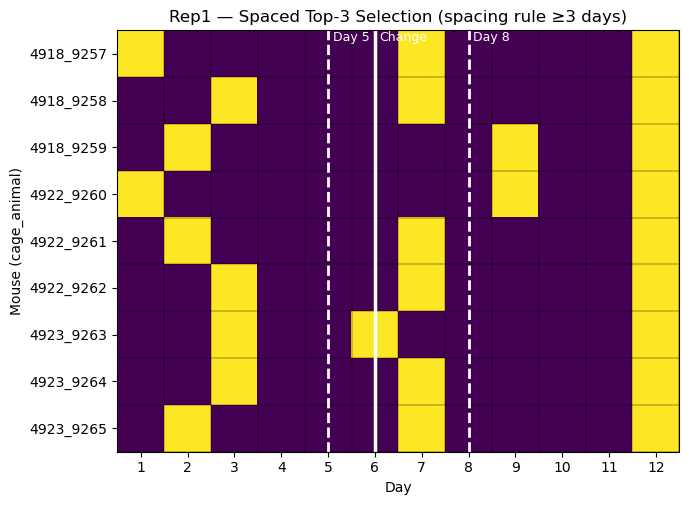

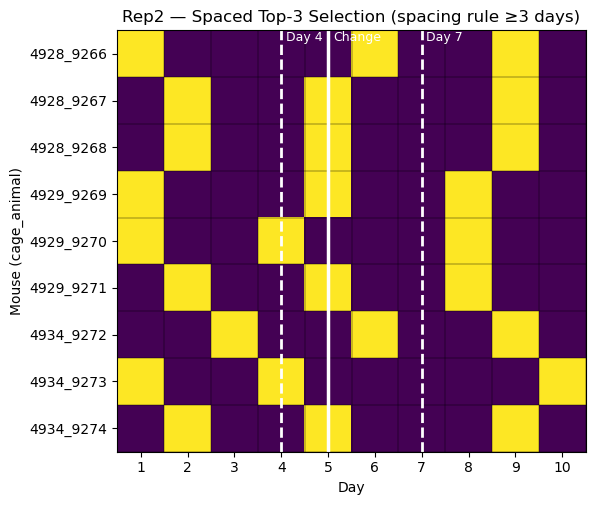

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ------------------------------------------------------------
# Event timestamps
# ------------------------------------------------------------
EVENTS = {
    "Rep1": {
        "dose_times": ["2025-01-14 06:00:00", "2025-01-17 17:00:00"],
        "cage_change_time": "2025-01-15 12:00:00",
        "start": "2025-01-10 06:00:00",
    },
    "Rep2": {
        "dose_times": ["2025-01-28 17:00:00", "2025-01-31 06:00:00"],
        "cage_change_time": "2025-01-29 12:00:00",
        "start": "2025-01-25 06:00:00",
    },
}

def _event_day_index(event_ts: str, start_ts: str) -> int:
    event = pd.to_datetime(event_ts)
    start = pd.to_datetime(start_ts)
    return int(np.floor((event - start).total_seconds() / (24 * 3600))) + 1


def selection_heatmap_per_mouse(topk_df: pd.DataFrame,
                                df_daily_all: pd.DataFrame,
                                title: str,
                                rep_label: str):

    df = topk_df.copy()
    df["mouse_label"] = df["cage_id"].astype(str) + "_" + df["animal_id"].astype(str)

    # Binary selection matrix
    mat = (
        df.assign(selected=1)
          .pivot_table(index="mouse_label",
                       columns="day",
                       values="selected",
                       fill_value=0)
          .sort_index()
    )

    # Force ALL study days to appear
    all_days = sorted(df_daily_all["day"].unique())
    mat = mat.reindex(columns=all_days, fill_value=0)

    n_rows, n_cols = mat.shape

    fig, ax = plt.subplots(figsize=(n_cols * 0.7 + 2, n_rows * 0.35 + 2))
    ax.imshow(mat.values, aspect='equal')

    ax.set_xticks(np.arange(n_cols))
    ax.set_yticks(np.arange(n_rows))

    ax.set_xticklabels(all_days)
    ax.set_yticklabels(mat.index)

    ax.set_xlabel("Day")
    ax.set_ylabel("Mouse (cage_animal)")
    ax.set_title(title)

    # Gridlines
    ax.set_xticks(np.arange(-.5, n_cols, 1), minor=True)
    ax.set_yticks(np.arange(-.5, n_rows, 1), minor=True)
    ax.grid(which="minor", color="black", linestyle='-', linewidth=0.3)
    ax.tick_params(which="minor", bottom=False, left=False)

    # ------------------------------------------------------------
    # Add Event Markers
    # ------------------------------------------------------------
    start_ts = EVENTS[rep_label]["start"]
    dose_days = [_event_day_index(t, start_ts) for t in EVENTS[rep_label]["dose_times"]]
    cage_change_day = _event_day_index(EVENTS[rep_label]["cage_change_time"], start_ts)

    day_to_col = {d: j for j, d in enumerate(all_days)}

    # Cage change (solid white line)
    if cage_change_day in day_to_col:
        x = day_to_col[cage_change_day]
        ax.axvline(x, color="white", linewidth=2.5)
        ax.text(x + 0.1, -0.8, "Cage\nChange",
                color="white", fontsize=9, ha="left", va="top")

    # Dose days (dashed white lines)
    for dd in dose_days:
        if dd in day_to_col:
            x = day_to_col[dd]
            ax.axvline(x, color="white", linestyle="--", linewidth=2)
            ax.text(x + 0.1, -0.8, f"Dose\nDay {dd}",
                    color="white", fontsize=9, ha="left", va="top")

    plt.tight_layout()
    plt.show()


# ------------------------------------------------------------
# RUN (SPACING RULE VERSION)
# ------------------------------------------------------------
selection_heatmap_per_mouse(
    rep1_mouse_top3,
    rep1_daily_all,
    "Rep1 — Spaced Top-3 Selection (spacing rule ≥3 days)",
    rep_label="Rep1"
)

selection_heatmap_per_mouse(
    rep2_mouse_top3,
    rep2_daily_all,
    "Rep2 — Spaced Top-3 Selection (spacing rule ≥3 days)",
    rep_label="Rep2"
)


In [8]:
import pandas as pd
import numpy as np

# ============================================================
# Pick top-3 days per cage (or per mouse) by mean/plateau
# NO spacing rule (just the 3 largest values)
# Assumes you already have:
#   rep1_ranks, rep2_ranks  (per-cage day stats with mean_plateau)
#   rep1_daily_all, rep2_daily_all (per-animal per-day with plateau_duration_min)
# ============================================================

TOP_K = 3

# -------------------------
# Per CAGE: top-3 days by mean plateau (no spacing)
# -------------------------
def topk_days_per_cage_no_spacing(ranks_df: pd.DataFrame, k: int = TOP_K) -> pd.DataFrame:
    """
    ranks_df columns expected:
      cage_id, day, mean_plateau, median_plateau, sd_plateau, n_animals, rank_mean_desc
    Returns: one row per (cage_id, pick_rank) with the top-k days.
    """
    out = []
    for cage_id, g in ranks_df.groupby("cage_id", sort=True):
        top = g.sort_values("mean_plateau", ascending=False).head(k).copy()
        top["pick_rank"] = np.arange(1, len(top) + 1)
        top["cage_id"] = cage_id
        out.append(top)
    return pd.concat(out, ignore_index=True) if out else pd.DataFrame()

rep1_cage_top3_nospacing = topk_days_per_cage_no_spacing(rep1_ranks, k=3)
rep2_cage_top3_nospacing = topk_days_per_cage_no_spacing(rep2_ranks, k=3)

print("\n=== Rep1: top-3 days per cage by MEAN plateau (no spacing) ===")
for cage_id, g in rep1_cage_top3_nospacing.groupby("cage_id", sort=True):
    print(f"\n--- Cage {cage_id} ---")
    print(g[["day","mean_plateau","median_plateau","sd_plateau","n_animals","pick_rank"]].to_string(index=False))

print("\n=== Rep2: top-3 days per cage by MEAN plateau (no spacing) ===")
for cage_id, g in rep2_cage_top3_nospacing.groupby("cage_id", sort=True):
    print(f"\n--- Cage {cage_id} ---")
    print(g[["day","mean_plateau","median_plateau","sd_plateau","n_animals","pick_rank"]].to_string(index=False))


# -------------------------
# (Optional) Per MOUSE: top-3 days by that mouse's plateau_duration_min (no spacing)
# -------------------------
def topk_days_per_mouse_no_spacing(df_daily_all: pd.DataFrame, k: int = TOP_K) -> pd.DataFrame:
    """
    df_daily_all columns expected:
      cage_id, animal_id, day, plateau_duration_min
    Returns: one row per (cage_id, animal_id, pick_rank) with top-k days.
    """
    out = []
    for (cage_id, animal_id), g in df_daily_all.groupby(["cage_id","animal_id"], sort=True):
        top = g.sort_values("plateau_duration_min", ascending=False).head(k).copy()
        top["pick_rank"] = np.arange(1, len(top) + 1)
        top["cage_id"] = cage_id
        top["animal_id"] = animal_id
        out.append(top[["cage_id","animal_id","day","plateau_duration_min","pick_rank"]])
    return pd.concat(out, ignore_index=True) if out else pd.DataFrame()

rep1_mouse_top3_nospacing = topk_days_per_mouse_no_spacing(rep1_daily_all, k=3)
rep2_mouse_top3_nospacing = topk_days_per_mouse_no_spacing(rep2_daily_all, k=3)

print("\n=== Rep1: top-3 days per mouse by PLATEAU duration (no spacing) ===")
for (cage_id, animal_id), g in rep1_mouse_top3_nospacing.groupby(["cage_id","animal_id"], sort=True):
    print(f"\n--- Cage {cage_id} | Mouse {animal_id} ---")
    print(g.sort_values("pick_rank").to_string(index=False))

print("\n=== Rep2: top-3 days per mouse by PLATEAU duration (no spacing) ===")
for (cage_id, animal_id), g in rep2_mouse_top3_nospacing.groupby(["cage_id","animal_id"], sort=True):
    print(f"\n--- Cage {cage_id} | Mouse {animal_id} ---")
    print(g.sort_values("pick_rank").to_string(index=False))



=== Rep1: top-3 days per cage by MEAN plateau (no spacing) ===

--- Cage 4918 ---
 day  mean_plateau  median_plateau  sd_plateau  n_animals  pick_rank
  12    238.000000           231.0   40.951190          3          1
   3    184.666667           192.0   13.576941          3          2
   7    172.666667           186.0   31.214313          3          3

--- Cage 4922 ---
 day  mean_plateau  median_plateau  sd_plateau  n_animals  pick_rank
  12    213.333333           212.0   12.055428          3          1
   1    173.333333           169.0   23.797759          3          2
   2    171.000000           168.0   11.789826          3          3

--- Cage 4923 ---
 day  mean_plateau  median_plateau  sd_plateau  n_animals  pick_rank
  12    236.333333           224.0   34.210135          3          1
   2    179.333333           169.0   18.770544          3          2
   3    177.333333           174.0    8.504901          3          3

=== Rep2: top-3 days per cage by MEAN plateau (no 

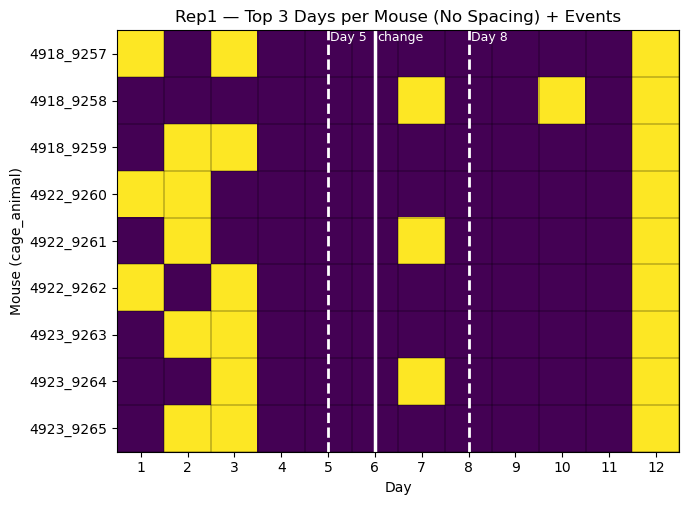

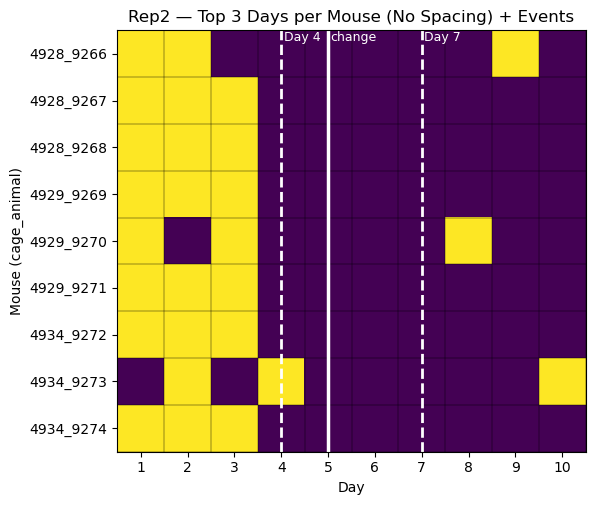

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ------------------------------------------------------------
# Event timestamps (from you)
# ------------------------------------------------------------
EVENTS = {
    "Rep1": {
        "dose_times": ["2025-01-14 06:00:00", "2025-01-17 17:00:00"],
        "cage_change_time": "2025-01-15 12:00:00",
        "start": "2025-01-10 06:00:00",
    },
    "Rep2": {
        "dose_times": ["2025-01-28 17:00:00", "2025-01-31 06:00:00"],
        "cage_change_time": "2025-01-29 12:00:00",
        "start": "2025-01-25 06:00:00",
    },
}

def _event_day_index(event_ts: str, start_ts: str) -> int:
    event = pd.to_datetime(event_ts)
    start = pd.to_datetime(start_ts)
    return int(np.floor((event - start).total_seconds() / (24 * 3600))) + 1

def plot_topk_heatmap_all_days_with_events(topk_df, df_daily_all, title, index_col, rep_label):
    # Build binary selection matrix
    mat = (
        topk_df.assign(selected=1)
              .pivot_table(index=index_col, columns="day", values="selected", fill_value=0)
              .sort_index()
    )

    # Force ALL study days to appear
    all_days = sorted(df_daily_all["day"].unique())
    mat = mat.reindex(columns=all_days, fill_value=0)

    n_rows, n_cols = mat.shape

    fig, ax = plt.subplots(figsize=(n_cols * 0.7 + 2, n_rows * 0.35 + 2))
    ax.imshow(mat.values, aspect="equal")

    # ticks/labels
    ax.set_xticks(np.arange(n_cols))
    ax.set_yticks(np.arange(n_rows))
    ax.set_xticklabels(all_days)
    ax.set_yticklabels(mat.index)

    ax.set_xlabel("Day")
    ax.set_ylabel("Mouse (cage_animal)")
    ax.set_title(title)

    # cell grid
    ax.set_xticks(np.arange(-.5, n_cols, 1), minor=True)
    ax.set_yticks(np.arange(-.5, n_rows, 1), minor=True)
    ax.grid(which="minor", color="black", linestyle='-', linewidth=0.3)
    ax.tick_params(which="minor", bottom=False, left=False)

    # -------------------------
    # Event markers (dose + cage change)
    # -------------------------
    start_ts = EVENTS[rep_label]["start"]
    dose_days = [_event_day_index(t, start_ts) for t in EVENTS[rep_label]["dose_times"]]
    cage_change_day = _event_day_index(EVENTS[rep_label]["cage_change_time"], start_ts)

    day_to_col = {d: j for j, d in enumerate(all_days)}

    # cage change = solid
    if cage_change_day in day_to_col:
        x = day_to_col[cage_change_day]
        ax.axvline(x, color="white", linewidth=2.5)
        ax.text(x + 0.05, -0.8, "Cage\nchange", color="white", fontsize=9, ha="left", va="top")

    # doses = dashed
    for dd in dose_days:
        if dd in day_to_col:
            x = day_to_col[dd]
            ax.axvline(x, color="white", linewidth=2.0, linestyle="--")
            ax.text(x + 0.05, -0.8, f"Dose\nDay {dd}", color="white", fontsize=9, ha="left", va="top")

    plt.tight_layout()
    plt.show()

# ------------------------------------------------------------
# RUN (NO SPACING RULE) + EVENTS
# Assumes mouse_label already exists in rep1_mouse_top3_nospacing / rep2_mouse_top3_nospacing
# ------------------------------------------------------------
plot_topk_heatmap_all_days_with_events(
    rep1_mouse_top3_nospacing,
    rep1_daily_all,
    "Rep1 — Top 3 Days per Mouse (No Spacing) + Events",
    "mouse_label",
    rep_label="Rep1"
)

plot_topk_heatmap_all_days_with_events(
    rep2_mouse_top3_nospacing,
    rep2_daily_all,
    "Rep2 — Top 3 Days per Mouse (No Spacing) + Events",
    "mouse_label",
    rep_label="Rep2"
)


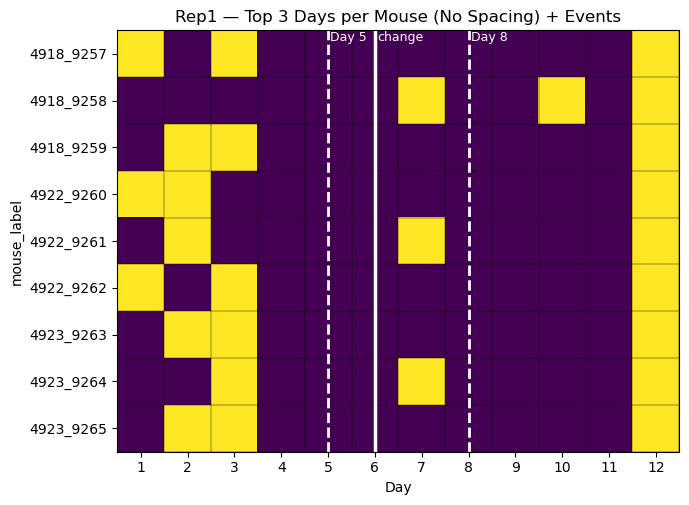

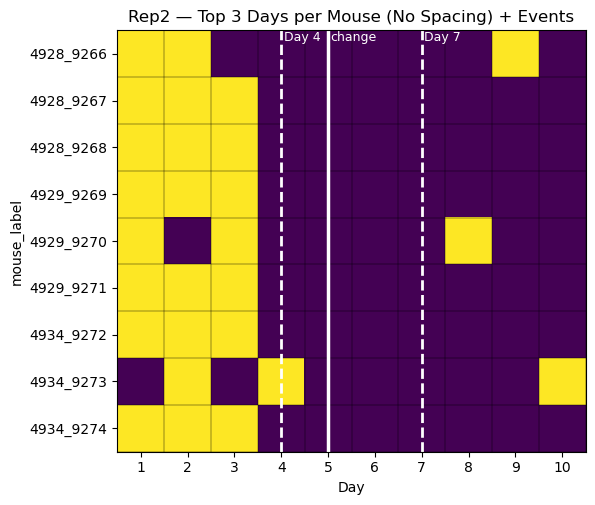

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ------------------------------------------------------------
# Event timestamps (from you)
# ------------------------------------------------------------
EVENTS = {
    "Rep1": {
        "dose_times": ["2025-01-14 06:00:00", "2025-01-17 17:00:00"],
        "cage_change_time": "2025-01-15 12:00:00",
        "start": "2025-01-10 06:00:00",
    },
    "Rep2": {
        "dose_times": ["2025-01-28 17:00:00", "2025-01-31 06:00:00"],
        "cage_change_time": "2025-01-29 12:00:00",
        "start": "2025-01-25 06:00:00",
    },
}

def _event_day_index(event_ts: str, start_ts: str) -> int:
    event = pd.to_datetime(event_ts)
    start = pd.to_datetime(start_ts)
    return int(np.floor((event - start).total_seconds() / (24 * 3600))) + 1

def plot_topk_heatmap_all_days_with_events(topk_df, df_daily_all, title, index_col,
                                          rep_label: str):
    """
    Heatmap of selected days (binary) with ALL days shown + vertical markers:
      - Dose days (dashed)
      - Cage change day (solid)
    topk_df must have columns: day and index_col
    df_daily_all provides full set of days in the window
    """

    # Binary selection matrix
    mat = (
        topk_df.assign(selected=1)
              .pivot_table(index=index_col, columns="day", values="selected", fill_value=0)
              .sort_index()
    )

    # Force all days to appear
    all_days = sorted(df_daily_all["day"].unique())
    mat = mat.reindex(columns=all_days, fill_value=0)

    n_rows, n_cols = mat.shape

    fig, ax = plt.subplots(figsize=(n_cols * 0.7 + 2, n_rows * 0.35 + 2))
    ax.imshow(mat.values, aspect="equal")

    # Ticks/labels
    ax.set_xticks(np.arange(n_cols))
    ax.set_yticks(np.arange(n_rows))
    ax.set_xticklabels(all_days)
    ax.set_yticklabels(mat.index)
    ax.set_xlabel("Day")
    ax.set_ylabel(index_col)
    ax.set_title(title)

    # Cell grid
    ax.set_xticks(np.arange(-.5, n_cols, 1), minor=True)
    ax.set_yticks(np.arange(-.5, n_rows, 1), minor=True)
    ax.grid(which="minor", color="black", linestyle='-', linewidth=0.3)
    ax.tick_params(which="minor", bottom=False, left=False)

    # -------------------------
    # Event markers
    # -------------------------
    start_ts = EVENTS[rep_label]["start"]
    dose_days = [_event_day_index(t, start_ts) for t in EVENTS[rep_label]["dose_times"]]
    cage_change_day = _event_day_index(EVENTS[rep_label]["cage_change_time"], start_ts)

    # Map day -> column position (0..n_cols-1)
    day_to_col = {d: j for j, d in enumerate(all_days)}

    # Cage change: solid line
    if cage_change_day in day_to_col:
        x = day_to_col[cage_change_day]
        ax.axvline(x, color="white", linewidth=2.5)
        ax.text(x + 0.05, -0.8, "Cage\nchange", color="white", fontsize=9, ha="left", va="top")

    # Dose days: dashed lines
    for dd in dose_days:
        if dd in day_to_col:
            x = day_to_col[dd]
            ax.axvline(x, color="white", linewidth=2.0, linestyle="--")
            ax.text(x + 0.05, -0.8, f"Dose\nDay {dd}", color="white", fontsize=9, ha="left", va="top")

    plt.tight_layout()
    plt.show()

# ------------------------------------------------------------
# RUN (example: NO spacing top-3 per mouse)
# Assumes you already created mouse_label cols:
#   rep1_mouse_top3_nospacing["mouse_label"], rep2_mouse_top3_nospacing["mouse_label"]
# ------------------------------------------------------------

plot_topk_heatmap_all_days_with_events(
    rep1_mouse_top3_nospacing, rep1_daily_all,
    "Rep1 — Top 3 Days per Mouse (No Spacing) + Events",
    index_col="mouse_label",
    rep_label="Rep1"
)

plot_topk_heatmap_all_days_with_events(
    rep2_mouse_top3_nospacing, rep2_daily_all,
    "Rep2 — Top 3 Days per Mouse (No Spacing) + Events",
    index_col="mouse_label",
    rep_label="Rep2"
)


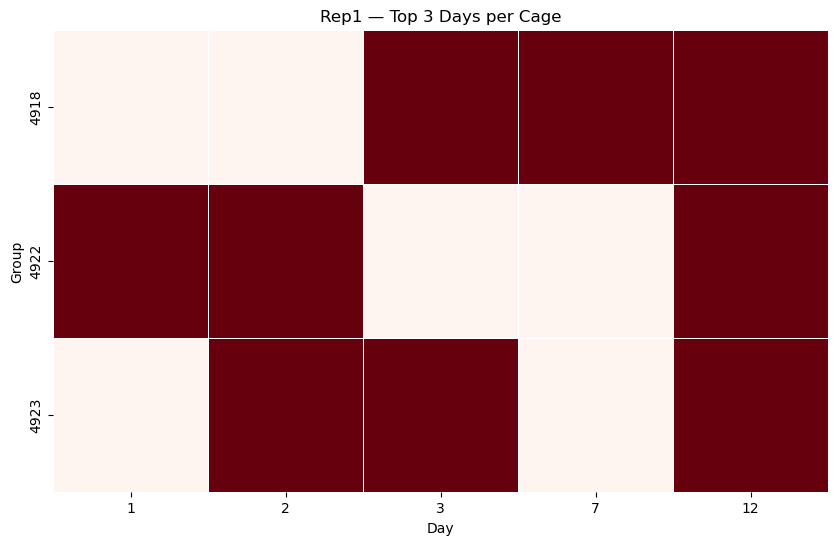

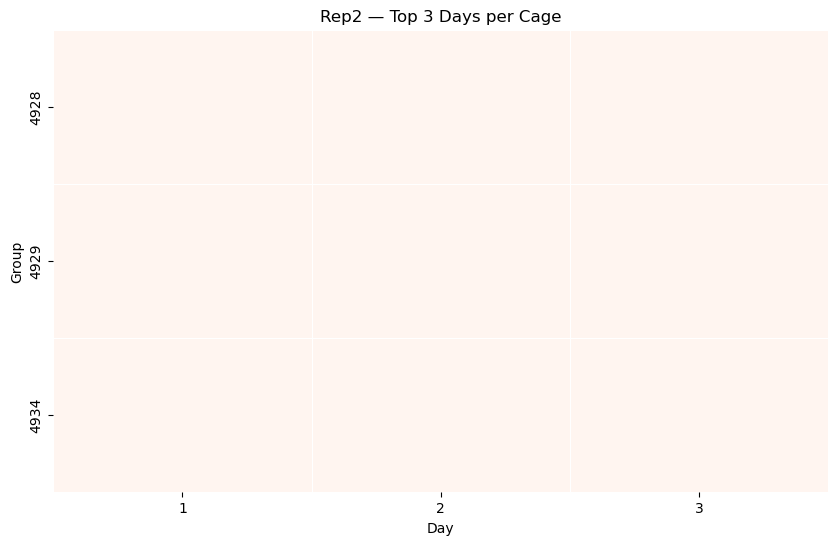

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_topk_heatmap(topk_df, title, group_cols):
    mat = (
        topk_df
        .assign(selected=1)
        .pivot_table(index=group_cols,
                     columns="day",
                     values="selected",
                     fill_value=0)
        .sort_index()
    )

    plt.figure(figsize=(10,6))
    sns.heatmap(mat, cmap="Reds", cbar=False, linewidths=0.5)
    plt.title(title)
    plt.xlabel("Day")
    plt.ylabel("Group")
    plt.show()

# Per cage
plot_topk_heatmap(rep1_cage_top3_nospacing,
                  "Rep1 — Top 3 Days per Cage",
                  "cage_id")

plot_topk_heatmap(rep2_cage_top3_nospacing,
                  "Rep2 — Top 3 Days per Cage",
                  "cage_id")


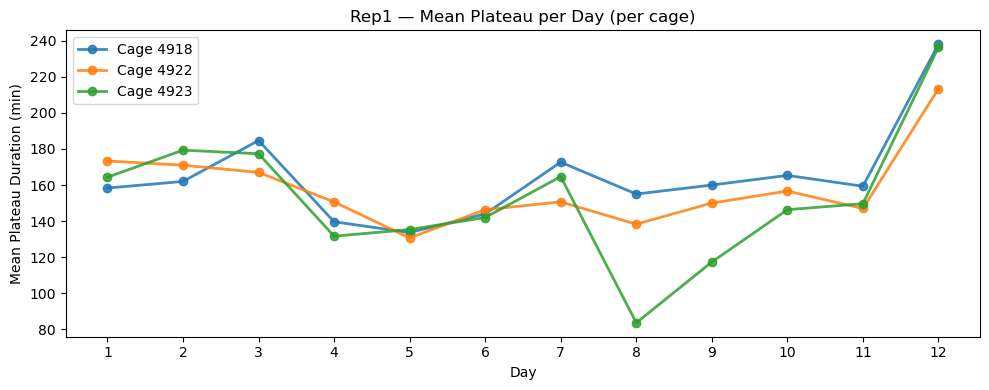

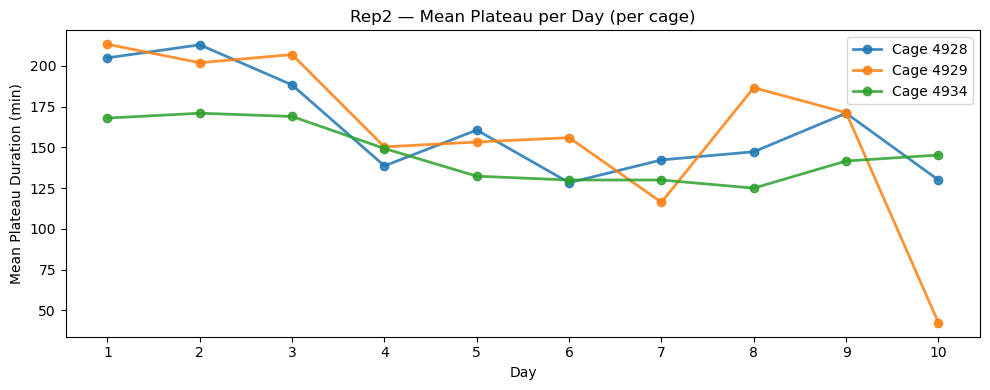

In [19]:
import matplotlib.pyplot as plt

def plot_day_means_per_cage(ranks_df, title):
    plt.figure(figsize=(10, 4))

    for cage_id, g in ranks_df.groupby("cage_id", sort=True):
        g = g.copy()
        g["day"] = g["day"].astype(int)
        g = g.sort_values("day")  # <-- critical fix

        plt.plot(g["day"], g["mean_plateau"], marker="o", linewidth=2, alpha=0.85, label=f"Cage {cage_id}")

    plt.title(title)
    plt.xlabel("Day")
    plt.ylabel("Mean Plateau Duration (min)")
    plt.xticks(sorted(ranks_df["day"].astype(int).unique()))
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_day_means_per_cage(rep1_ranks, "Rep1 — Mean Plateau per Day (per cage)")
plot_day_means_per_cage(rep2_ranks, "Rep2 — Mean Plateau per Day (per cage)")


In [5]:
import numpy as np
import pandas as pd

# ============================================================
# CONFIG
# ============================================================
MINUTES_PER_DAY = 1440
DAYS_PER_CYCLE = 4
MINUTES_PER_CYCLE = DAYS_PER_CYCLE * MINUTES_PER_DAY

# ============================================================
# LOAD SMARR FEMALE DATA (ALIGNED)
# ============================================================
def load_smarr_female_data(csv_path):
    df_smarr = pd.read_csv(csv_path)

    # Select female columns
    female_cols = [
        c for c in df_smarr.columns
        if str(c).lower().startswith("fem")
    ]

    if len(female_cols) == 0:
        raise ValueError("No female columns found (expected columns starting with 'fem').")

    # Shape: (n_females, n_timepoints)
    female_data = df_smarr[female_cols].to_numpy().T

    n_females, n_timepoints = female_data.shape
    print(f"Loaded Smarr data: {n_females} females, {n_timepoints} minutes")

    # Keep only complete 4-day cycles
    n_cycles = n_timepoints // MINUTES_PER_CYCLE
    if n_cycles < 1:
        raise ValueError("Not enough data for a complete 4-day cycle.")

    female_data = female_data[:, :n_cycles * MINUTES_PER_CYCLE]

    print(f"Using {n_cycles} complete 4-day cycles")
    return female_data, n_females, n_cycles


# ============================================================
# BUILD MEDIAN 4-DAY PROFILE (ALIGNED)
# ============================================================
def build_smarr_median_4day(female_data, n_females, n_cycles):
    reshaped = female_data.reshape(
        n_females, n_cycles, MINUTES_PER_CYCLE
    )  # (females, cycles, minutes)

    median_per_female = np.median(reshaped, axis=1)
    smarr_median_4day = np.median(median_per_female, axis=0)

    return smarr_median_4day


# ============================================================
# MAXIMAL DEALIGNMENT (NEGATIVE CONTROL)
# ============================================================
def build_smarr_dealigned(female_data, n_females, n_cycles):
    misaligned = np.empty_like(female_data)

    for i in range(n_females):
        # Shift each female by a full-day increment
        shift = (i * MINUTES_PER_DAY) % female_data.shape[1]
        misaligned[i] = np.roll(female_data[i], -shift)

    reshaped_mis = misaligned.reshape(
        n_females, n_cycles, MINUTES_PER_CYCLE
    )

    median_per_female_mis = np.median(reshaped_mis, axis=1)
    smarr_misaligned_median_4day = np.median(median_per_female_mis, axis=0)

    return misaligned, smarr_misaligned_median_4day


# ============================================================
# RUN EVERYTHING
# ============================================================

csv_path = "mice data.xlsx - FemAct (1).csv"

female_data, n_females, n_cycles = load_smarr_female_data(csv_path)

smarr_median_4day = build_smarr_median_4day(
    female_data, n_females, n_cycles
)

female_data_dealigned, smarr_misaligned_median_4day = build_smarr_dealigned(
    female_data, n_females, n_cycles
)

print("\nAligned 4-day median profile shape:", smarr_median_4day.shape)
print("Dealigned 4-day median profile shape:", smarr_misaligned_median_4day.shape)


Loaded Smarr data: 14 females, 11520 minutes
Using 2 complete 4-day cycles

Aligned 4-day median profile shape: (5760,)
Dealigned 4-day median profile shape: (5760,)


In [6]:
import numpy as np
import pandas as pd

# ============================================================
# CONFIG
# ============================================================
MINUTES_PER_DAY = 1440
DARK_START = 0
DARK_END = 720
PLATEAU_Q = 85
MIN_GAP_DAYS = 3
TOP_K = 3

# ============================================================
# CORE FUNCTION: PLATEAU DAILY
# ============================================================
def smarr_plateau_daily(female_data, q=PLATEAU_Q):
    n_females, n_minutes = female_data.shape
    n_days = n_minutes // MINUTES_PER_DAY

    results = []

    for i in range(n_females):
        mouse = female_data[i]

        # reshape into days
        mouse_days = mouse[:n_days * MINUTES_PER_DAY]
        mouse_days = mouse_days.reshape(n_days, MINUTES_PER_DAY)

        # dark phase only
        dark = mouse_days[:, DARK_START:DARK_END]

        # robust threshold from median dark profile
        median_profile = np.median(dark, axis=0)
        threshold = np.percentile(median_profile, q)

        for day_idx in range(n_days):
            dark_vals = dark[day_idx]
            plateau_minutes = np.sum(dark_vals >= threshold)

            results.append({
                "female_id": i + 1,
                "day": day_idx + 1,
                "plateau_duration_min": plateau_minutes
            })

    return pd.DataFrame(results)

# ============================================================
# RANK DAYS PER MOUSE
# ============================================================
def rank_days_per_mouse(df_daily):
    df = df_daily.copy()
    df["rank_plateau_desc"] = (
        df.groupby("female_id")["plateau_duration_min"]
          .rank(ascending=False, method="min")
          .astype(int)
    )
    return df.sort_values(["female_id","rank_plateau_desc","day"]).reset_index(drop=True)

# ============================================================
# PICK TOP K SPACED DAYS
# ============================================================
def pick_top_k_spaced(df_daily, k=TOP_K, min_gap_days=MIN_GAP_DAYS):
    results = []

    for female_id, g in df_daily.groupby("female_id"):
        g_sorted = g.sort_values("plateau_duration_min", ascending=False)
        chosen = []

        for _, row in g_sorted.iterrows():
            d = int(row["day"])
            if all(abs(d - int(c["day"])) >= min_gap_days for c in chosen):
                chosen.append(row)
            if len(chosen) == k:
                break

        if chosen:
            picked = pd.DataFrame(chosen)
            picked["pick_rank"] = (
                picked["plateau_duration_min"]
                .rank(ascending=False, method="first")
                .astype(int)
            )
            results.append(picked)

    return pd.concat(results, ignore_index=True)

# ============================================================
# RUN FOR SMARR ALIGNED
# ============================================================
smarr_aligned_daily = smarr_plateau_daily(female_data)
smarr_aligned_ranked = rank_days_per_mouse(smarr_aligned_daily)
smarr_aligned_top3 = pick_top_k_spaced(smarr_aligned_daily)

# ============================================================
# RUN FOR SMARR DEALIGNED
# ============================================================
smarr_dealigned_daily = smarr_plateau_daily(female_data_dealigned)
smarr_dealigned_ranked = rank_days_per_mouse(smarr_dealigned_daily)
smarr_dealigned_top3 = pick_top_k_spaced(smarr_dealigned_daily)

# ============================================================
# PRINT RESULTS
# ============================================================

print("\n==============================")
print("SMARR ALIGNED — Top 3 Estrus-Like Days Per Mouse")
print("==============================")
for mouse, g in smarr_aligned_top3.groupby("female_id"):
    print(f"\n----- Female {mouse} -----")
    print(g.sort_values("pick_rank").to_string(index=False))

print("\n==============================")
print("SMARR DEALIGNED — Top 3 Estrus-Like Days Per Mouse")
print("==============================")
for mouse, g in smarr_dealigned_top3.groupby("female_id"):
    print(f"\n----- Female {mouse} -----")
    print(g.sort_values("pick_rank").to_string(index=False))

# Optional: view full ranked tables
# print(smarr_aligned_ranked)
# print(smarr_dealigned_ranked)



SMARR ALIGNED — Top 3 Estrus-Like Days Per Mouse

----- Female 1 -----
 female_id  day  plateau_duration_min  pick_rank
         1    5                   273          1
         1    1                   262          2
         1    8                   190          3

----- Female 2 -----
 female_id  day  plateau_duration_min  pick_rank
         2    1                   328          1
         2    5                   273          2
         2    8                   142          3

----- Female 3 -----
 female_id  day  plateau_duration_min  pick_rank
         3    2                   232          1
         3    5                   205          2
         3    8                   201          3

----- Female 4 -----
 female_id  day  plateau_duration_min  pick_rank
         4    1                   484          1
         4    5                   363          2
         4    8                   166          3

----- Female 5 -----
 female_id  day  plateau_duration_min  pick_rank
       

In [7]:
# 1) Global check: how many days do we actually have?
n_days_total = smarr_aligned_daily["day"].nunique()
print("Total unique days in Smarr aligned daily table:", n_days_total)

# 2) Per-mouse check: how many days exist + how many picks were made
picks_per_mouse = (
    smarr_aligned_top3.groupby("female_id")["day"]
    .nunique()
    .rename("n_picks")
    .reset_index()
)

days_per_mouse = (
    smarr_aligned_daily.groupby("female_id")["day"]
    .nunique()
    .rename("n_days_available")
    .reset_index()
)

diag = days_per_mouse.merge(picks_per_mouse, on="female_id", how="left").fillna({"n_picks": 0})
diag["n_picks"] = diag["n_picks"].astype(int)

print("\nPer-mouse availability vs picks (aligned):")
print(diag.sort_values(["n_picks","female_id"]).to_string(index=False))

# 3) For mice with only 2 picks, show the candidate days and why a 3rd can't be picked
min_gap_days = 3

def explain_mouse(female_id: int):
    g = smarr_aligned_daily.query("female_id == @female_id").copy()
    g = g.sort_values("plateau_duration_min", ascending=False)

    picked = smarr_aligned_top3.query("female_id == @female_id").sort_values("pick_rank")
    picked_days = picked["day"].tolist()

    print(f"\n========== Female {female_id} ==========")
    print("Days available:", sorted(g["day"].unique().tolist()))
    print("Picked days:", picked_days)

    # Show top candidates
    print("\nTop 10 candidate days by plateau_duration_min:")
    print(g.head(10)[["day","plateau_duration_min"]].to_string(index=False))

    # Show which days are blocked by spacing vs allowed
    def allowed(d):
        return all(abs(d - pd_day) >= min_gap_days for pd_day in picked_days)

    g["allowed_given_picks"] = g["day"].apply(lambda d: allowed(int(d)))
    print("\nAllowed days given spacing rule (after your picks):")
    print(g.sort_values(["allowed_given_picks","plateau_duration_min"], ascending=[False, False])[["day","plateau_duration_min","allowed_given_picks"]].head(20).to_string(index=False))

# run explain for all mice with 2 picks
two_pick_mice = diag.loc[diag["n_picks"] == 2, "female_id"].tolist()
print("\nMice with only 2 picks:", two_pick_mice)

for mid in two_pick_mice:
    explain_mouse(int(mid))


Total unique days in Smarr aligned daily table: 8

Per-mouse availability vs picks (aligned):
 female_id  n_days_available  n_picks
        12                 8        2
        14                 8        2
         1                 8        3
         2                 8        3
         3                 8        3
         4                 8        3
         5                 8        3
         6                 8        3
         7                 8        3
         8                 8        3
         9                 8        3
        10                 8        3
        11                 8        3
        13                 8        3

Mice with only 2 picks: [12, 14]

========== Female 12 ==========
Days available: [1, 2, 3, 4, 5, 6, 7, 8]
Picked days: [6, 1]

Top 10 candidate days by plateau_duration_min:
 day  plateau_duration_min
   6                   263
   5                   242
   8                   232
   7                   223
   1                   22

In [9]:
import numpy as np
import pandas as pd

# ============================================================
# SMARR: Top-2 days by MEAN plateau duration (across mice)
# Do this for:
#   - aligned Smarr
#   - dealigned Smarr
#
# Assumes you already have:
#   female_data            (aligned)   shape (n_females, n_minutes)
#   female_data_dealigned  (dealigned) shape (n_females, n_minutes)
# ============================================================

MINUTES_PER_DAY = 1440
DARK_START = 0
DARK_END = 720
PLATEAU_Q = 85

def smarr_plateau_daily(female_data, q=PLATEAU_Q):
    """
    Compute per-mouse per-day plateau duration during dark phase only.
    Robust threshold per mouse: qth percentile of that mouse's median dark profile.
    Returns DataFrame: female_id, day, plateau_duration_min
    """
    n_females, n_minutes = female_data.shape
    n_days = n_minutes // MINUTES_PER_DAY

    rows = []
    for i in range(n_females):
        x = female_data[i, :n_days * MINUTES_PER_DAY].reshape(n_days, MINUTES_PER_DAY)
        dark = x[:, DARK_START:DARK_END]  # (n_days, 720)

        median_profile = np.median(dark, axis=0)
        thr = float(np.percentile(median_profile, q))

        plateau = (dark >= thr).sum(axis=1)  # per day
        for d in range(n_days):
            rows.append({
                "female_id": i + 1,
                "day": d + 1,
                "plateau_duration_min": int(plateau[d])
            })

    return pd.DataFrame(rows)

def smarr_day_mean_plateau(df_daily: pd.DataFrame) -> pd.DataFrame:
    """
    Aggregate across mice: per-day mean/median/sd plateau duration.
    """
    return (
        df_daily
        .groupby("day", as_index=False)["plateau_duration_min"]
        .agg(
            mean_plateau="mean",
            median_plateau="median",
            sd_plateau="std",
            n_mice="count",
        )
        .sort_values("day")
        .reset_index(drop=True)
    )

def topk_days_by_mean(df_day_stats: pd.DataFrame, k: int = 2) -> pd.DataFrame:
    """
    Pick top-k days by mean plateau duration (no spacing rule).
    Adds pick_rank (1 = highest mean).
    """
    top = df_day_stats.sort_values("mean_plateau", ascending=False).head(k).copy()
    top["pick_rank"] = np.arange(1, len(top) + 1)
    return top[["day","mean_plateau","median_plateau","sd_plateau","n_mice","pick_rank"]]

# ----------------------------
# ALIGNED
# ----------------------------
smarr_aligned_daily = smarr_plateau_daily(female_data, q=PLATEAU_Q)
smarr_aligned_day_stats = smarr_day_mean_plateau(smarr_aligned_daily)
smarr_aligned_top2 = topk_days_by_mean(smarr_aligned_day_stats, k=2)

print("\n==============================")
print("SMARR ALIGNED — Top 2 days by MEAN plateau duration")
print("==============================")
print(smarr_aligned_top2.to_string(index=False))

# (Optional) full per-day table ranked
print("\nSMARR ALIGNED — All days ranked by mean plateau duration")
print(smarr_aligned_day_stats.sort_values("mean_plateau", ascending=False).to_string(index=False))

# ----------------------------
# DEALIGNED
# ----------------------------
smarr_dealigned_daily = smarr_plateau_daily(female_data_dealigned, q=PLATEAU_Q)
smarr_dealigned_day_stats = smarr_day_mean_plateau(smarr_dealigned_daily)
smarr_dealigned_top2 = topk_days_by_mean(smarr_dealigned_day_stats, k=2)

print("\n==============================")
print("SMARR DEALIGNED — Top 2 days by MEAN plateau duration")
print("==============================")
print(smarr_dealigned_top2.to_string(index=False))

# (Optional) full per-day table ranked
print("\nSMARR DEALIGNED — All days ranked by mean plateau duration")
print(smarr_dealigned_day_stats.sort_values("mean_plateau", ascending=False).to_string(index=False))



SMARR ALIGNED — Top 2 days by MEAN plateau duration
 day  mean_plateau  median_plateau  sd_plateau  n_mice  pick_rank
   1    284.428571           263.0   76.232150      14          1
   5    260.071429           253.5   50.516508      14          2

SMARR ALIGNED — All days ranked by mean plateau duration
 day  mean_plateau  median_plateau  sd_plateau  n_mice
   1    284.428571           263.0   76.232150      14
   5    260.071429           253.5   50.516508      14
   4    217.428571           213.5   33.906465      14
   2    200.857143           191.5   33.938535      14
   6    200.000000           201.5   55.554547      14
   7    191.428571           193.0   44.805072      14
   8    184.500000           185.5   34.547069      14
   3    183.642857           182.5   33.518324      14

SMARR DEALIGNED — Top 2 days by MEAN plateau duration
 day  mean_plateau  median_plateau  sd_plateau  n_mice  pick_rank
   6    230.357143           222.0   80.065941      14          1
   2    2

In [10]:
import numpy as np
import pandas as pd

# ============================================================
# CONFIG
# ============================================================
MINUTES_PER_DAY = 1440
DARK_START = 0
DARK_END = 720
PLATEAU_Q = 85
TOP_K = 2

# ============================================================
# CORE: Compute per-mouse daily plateau duration
# ============================================================
def smarr_plateau_daily(female_data, q=PLATEAU_Q):
    n_females, n_minutes = female_data.shape
    n_days = n_minutes // MINUTES_PER_DAY

    rows = []

    for i in range(n_females):
        x = female_data[i, :n_days * MINUTES_PER_DAY]
        x = x.reshape(n_days, MINUTES_PER_DAY)

        dark = x[:, DARK_START:DARK_END]

        # robust threshold per mouse
        median_profile = np.median(dark, axis=0)
        threshold = float(np.percentile(median_profile, q))

        plateau = (dark >= threshold).sum(axis=1)

        for d in range(n_days):
            rows.append({
                "female_id": i + 1,
                "day": d + 1,
                "plateau_duration_min": int(plateau[d])
            })

    return pd.DataFrame(rows)

# ============================================================
# Rank all days per mouse
# ============================================================
def rank_days_per_mouse(df_daily):
    df = df_daily.copy()
    df["rank_plateau_desc"] = (
        df.groupby("female_id")["plateau_duration_min"]
          .rank(ascending=False, method="min")
          .astype(int)
    )
    return df.sort_values(["female_id","rank_plateau_desc","day"]).reset_index(drop=True)

# ============================================================
# Pick top K days per mouse (no spacing)
# ============================================================
def topk_days_per_mouse(df_daily, k=TOP_K):
    out = []
    for female_id, g in df_daily.groupby("female_id", sort=True):
        top = g.sort_values("plateau_duration_min", ascending=False).head(k).copy()
        top["pick_rank"] = np.arange(1, len(top) + 1)
        out.append(top)
    return pd.concat(out, ignore_index=True)

# ============================================================
# RUN FOR SMARR ALIGNED
# ============================================================
smarr_aligned_daily = smarr_plateau_daily(female_data)
smarr_aligned_ranked = rank_days_per_mouse(smarr_aligned_daily)
smarr_aligned_top2 = topk_days_per_mouse(smarr_aligned_daily, k=2)

print("\n==============================")
print("SMARR ALIGNED — Top 2 Days Per Mouse (No Spacing)")
print("==============================")

for mouse, g in smarr_aligned_top2.groupby("female_id"):
    print(f"\n----- Female {mouse} -----")
    print(g.sort_values("pick_rank")[["day","plateau_duration_min","pick_rank"]].to_string(index=False))

# ============================================================
# RUN FOR SMARR DEALIGNED
# ============================================================
smarr_dealigned_daily = smarr_plateau_daily(female_data_dealigned)
smarr_dealigned_ranked = rank_days_per_mouse(smarr_dealigned_daily)
smarr_dealigned_top2 = topk_days_per_mouse(smarr_dealigned_daily, k=2)

print("\n==============================")
print("SMARR DEALIGNED — Top 2 Days Per Mouse (No Spacing)")
print("==============================")

for mouse, g in smarr_dealigned_top2.groupby("female_id"):
    print(f"\n----- Female {mouse} -----")
    print(g.sort_values("pick_rank")[["day","plateau_duration_min","pick_rank"]].to_string(index=False))

# Optional: see full ranking tables
# print(smarr_aligned_ranked)
# print(smarr_dealigned_ranked)



SMARR ALIGNED — Top 2 Days Per Mouse (No Spacing)

----- Female 1 -----
 day  plateau_duration_min  pick_rank
   5                   273          1
   6                   271          2

----- Female 2 -----
 day  plateau_duration_min  pick_rank
   1                   328          1
   5                   273          2

----- Female 3 -----
 day  plateau_duration_min  pick_rank
   2                   232          1
   1                   228          2

----- Female 4 -----
 day  plateau_duration_min  pick_rank
   1                   484          1
   5                   363          2

----- Female 5 -----
 day  plateau_duration_min  pick_rank
   1                   329          1
   5                   239          2

----- Female 6 -----
 day  plateau_duration_min  pick_rank
   1                   348          1
   5                   305          2

----- Female 7 -----
 day  plateau_duration_min  pick_rank
   4                   234          1
   1                   227         

In [12]:
import duckdb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

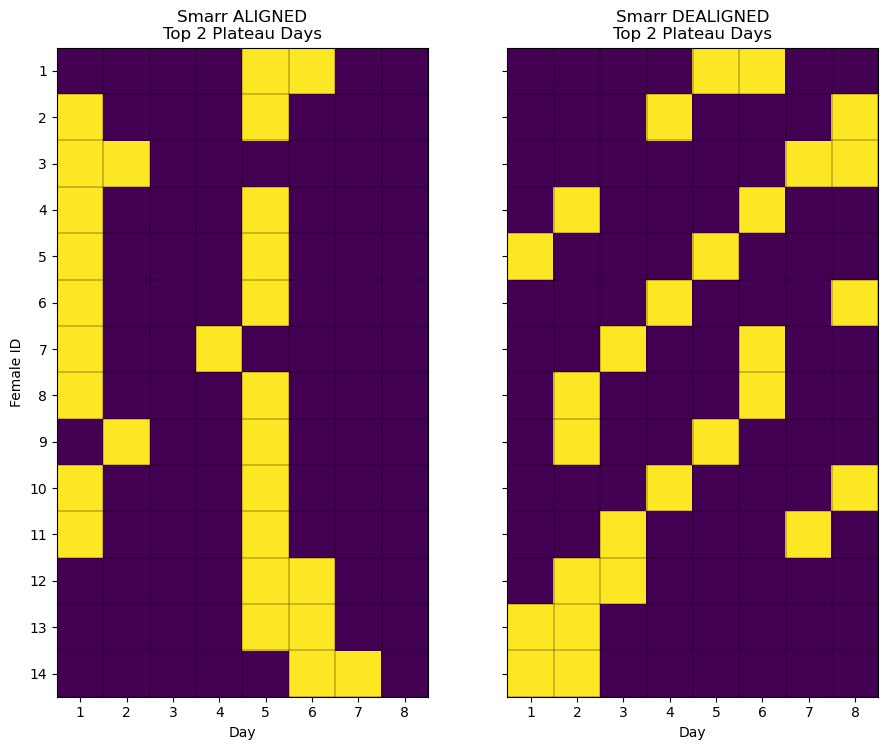

In [29]:
import numpy as np
import matplotlib.pyplot as plt

def build_selection_matrix(top2_df, df_daily):
    mat = (
        top2_df
        .assign(selected=1)
        .pivot_table(index="female_id",
                     columns="day",
                     values="selected",
                     fill_value=0)
        .sort_index()
    )

    # Force all study days
    all_days = sorted(df_daily["day"].unique())
    mat = mat.reindex(columns=all_days, fill_value=0)

    return mat, all_days


def smarr_side_by_side_heatmap(aligned_top2,
                               aligned_daily,
                               dealigned_top2,
                               dealigned_daily):

    mat_aligned, days = build_selection_matrix(aligned_top2, aligned_daily)
    mat_dealigned, _ = build_selection_matrix(dealigned_top2, dealigned_daily)

    n_rows, n_cols = mat_aligned.shape

    fig, axes = plt.subplots(
        1, 2,
        figsize=(n_cols * 1.2, n_rows * 0.4 + 2),
        sharey=True
    )

    # ---- ALIGNED ----
    im1 = axes[0].imshow(mat_aligned.values, aspect="equal")
    axes[0].set_title("Smarr ALIGNED\nTop 2 Plateau Days")
    axes[0].set_xticks(np.arange(n_cols))
    axes[0].set_xticklabels(days)
    axes[0].set_yticks(np.arange(n_rows))
    axes[0].set_yticklabels(mat_aligned.index)
    axes[0].set_xlabel("Day")
    axes[0].set_ylabel("Female ID")

    # ---- DEALIGNED ----
    im2 = axes[1].imshow(mat_dealigned.values, aspect="equal")
    axes[1].set_title("Smarr DEALIGNED\nTop 2 Plateau Days")
    axes[1].set_xticks(np.arange(n_cols))
    axes[1].set_xticklabels(days)
    axes[1].set_xlabel("Day")

    # Gridlines for both
    for ax in axes:
        ax.set_xticks(np.arange(-.5, n_cols, 1), minor=True)
        ax.set_yticks(np.arange(-.5, n_rows, 1), minor=True)
        ax.grid(which="minor", color="black", linestyle='-', linewidth=0.3)
        ax.tick_params(which="minor", bottom=False, left=False)

    plt.tight_layout()
    plt.show()


# ------------------------------------------------------------
# RUN
# ------------------------------------------------------------
smarr_side_by_side_heatmap(
    smarr_aligned_top2,
    smarr_aligned_daily,
    smarr_dealigned_top2,
    smarr_dealigned_daily
)


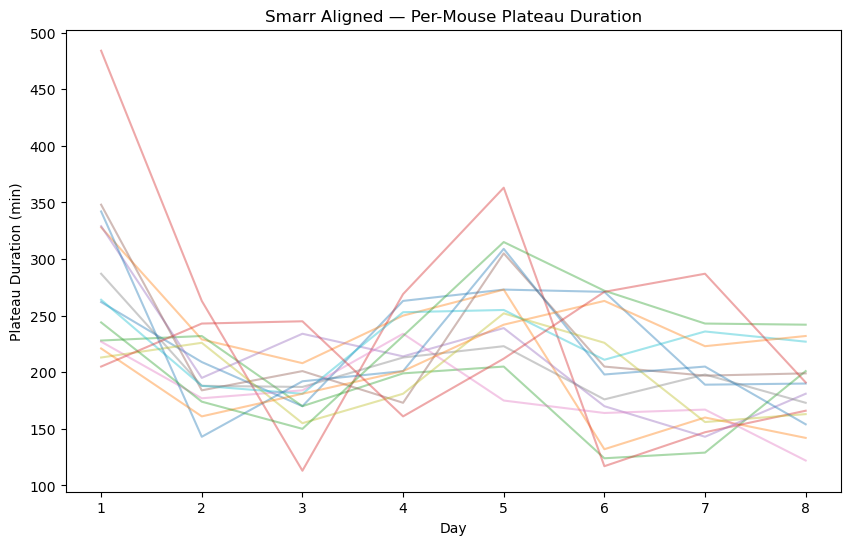

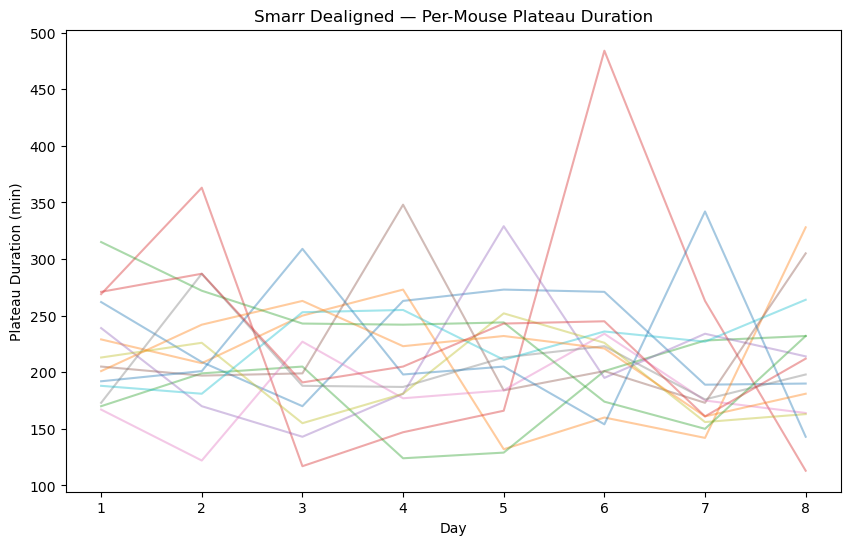

In [13]:
def plot_plateau_profiles(df_daily, title):
    plt.figure(figsize=(10,6))

    for mouse, g in df_daily.groupby("female_id"):
        plt.plot(g["day"], g["plateau_duration_min"], alpha=0.4)

    plt.title(title)
    plt.xlabel("Day")
    plt.ylabel("Plateau Duration (min)")
    plt.show()

plot_plateau_profiles(smarr_aligned_daily,
                      "Smarr Aligned — Per-Mouse Plateau Duration")

plot_plateau_profiles(smarr_dealigned_daily,
                      "Smarr Dealigned — Per-Mouse Plateau Duration")


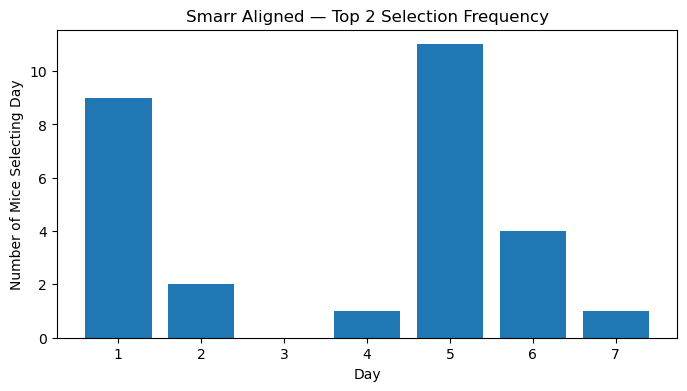

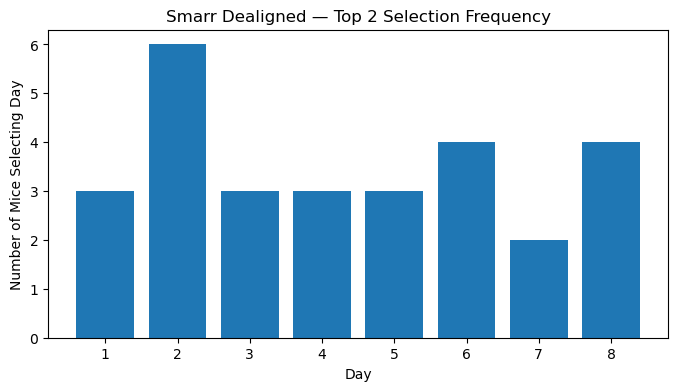

In [14]:
def plot_selection_frequency(top2_df, title):
    freq = top2_df["day"].value_counts().sort_index()

    plt.figure(figsize=(8,4))
    plt.bar(freq.index, freq.values)
    plt.title(title)
    plt.xlabel("Day")
    plt.ylabel("Number of Mice Selecting Day")
    plt.show()

plot_selection_frequency(smarr_aligned_top2,
                         "Smarr Aligned — Top 2 Selection Frequency")

plot_selection_frequency(smarr_dealigned_top2,
                         "Smarr Dealigned — Top 2 Selection Frequency")



SMARR ALIGNED — Permutation Test (Estrus vs Non-Estrus)
Statistic: mean(estrus - non-estrus) across mice
Observed T: 75.9405
Permutation p-value: 9.999e-05


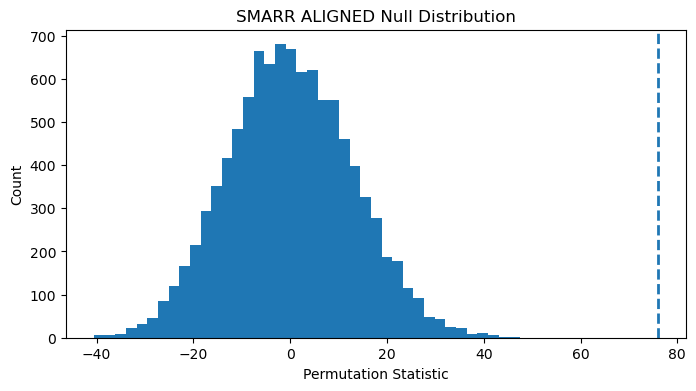


SMARR DEALIGNED — Permutation Test (Estrus vs Non-Estrus)
Statistic: mean(estrus - non-estrus) across mice
Observed T: 2.9881
Permutation p-value: 0.40436


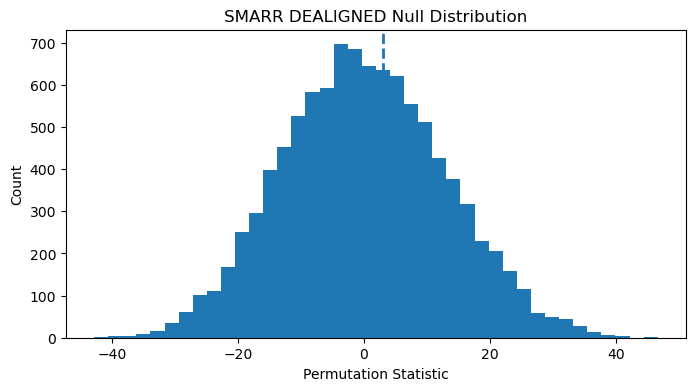

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ============================================================
# CONFIG
# ============================================================
ESTRUS_DAYS = [1, 5]
N_PERM = 10000
RNG_SEED = 0

rng = np.random.default_rng(RNG_SEED)

# ============================================================
# Core permutation function
# ============================================================
def smarr_permutation_test(df_daily, label):

    # -----------------------------
    # Compute observed statistic
    # -----------------------------
    obs_vals = []

    for mouse, g in df_daily.groupby("female_id"):
        estrus_mean = g[g["day"].isin(ESTRUS_DAYS)]["plateau_duration_min"].mean()
        non_estrus_mean = g[~g["day"].isin(ESTRUS_DAYS)]["plateau_duration_min"].mean()
        obs_vals.append(estrus_mean - non_estrus_mean)

    T_obs = np.mean(obs_vals)

    # -----------------------------
    # Permutation distribution
    # -----------------------------
    T_perm = np.zeros(N_PERM)

    grouped = list(df_daily.groupby("female_id"))

    for i in range(N_PERM):
        perm_vals = []

        for _, g in grouped:
            g_perm = g.copy()
            g_perm["day"] = rng.permutation(g_perm["day"].values)

            estrus_mean = g_perm[g_perm["day"].isin(ESTRUS_DAYS)]["plateau_duration_min"].mean()
            non_estrus_mean = g_perm[~g_perm["day"].isin(ESTRUS_DAYS)]["plateau_duration_min"].mean()

            perm_vals.append(estrus_mean - non_estrus_mean)

        T_perm[i] = np.mean(perm_vals)

    # one-sided (large positive = estrus structure)
    p_value = (np.sum(T_perm >= T_obs) + 1) / (N_PERM + 1)

    # -----------------------------
    # Print results
    # -----------------------------
    print("\n====================================================")
    print(f"{label} — Permutation Test (Estrus vs Non-Estrus)")
    print("Statistic: mean(estrus - non-estrus) across mice")
    print(f"Observed T: {T_obs:.4f}")
    print(f"Permutation p-value: {p_value:.6g}")
    print("====================================================")

    # -----------------------------
    # Plot null distribution
    # -----------------------------
    plt.figure(figsize=(8,4))
    plt.hist(T_perm, bins=40)
    plt.axvline(T_obs, linestyle="--", linewidth=2)
    plt.title(f"{label} Null Distribution")
    plt.xlabel("Permutation Statistic")
    plt.ylabel("Count")
    plt.show()

    return {
        "T_obs": T_obs,
        "p_value": p_value,
        "T_perm": T_perm
    }

# ============================================================
# RUN TESTS
# ============================================================

res_aligned = smarr_permutation_test(
    smarr_aligned_daily,
    "SMARR ALIGNED"
)

res_dealigned = smarr_permutation_test(
    smarr_dealigned_daily,
    "SMARR DEALIGNED"
)
